In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import numpy as np
import multiprocessing as mp
from IPython.display import display, Image, SVG

from pydrake.geometry import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import (
    HPolyhedron,
    Hyperellipsoid,
    IrisInConfigurationSpace,
    IrisOptions
)
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import RevoluteJoint
from pydrake.solvers import MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from reproduction.bimanual.helpers import *
from reproduction.util import *
os.environ['MOSEKLM_LICENSE_FILE'] = "/home/elaina/Downloads/mosek.lic"
mosek_license = MosekSolver.AcquireLicense()
mosek_license

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())
parser.package_map().Remove("drake")
parser.package_map().Add("drake", "/home/elaina/projects")
parser.package_map().Remove("drake_models")
parser.package_map().Add("drake_models", "/home/elaina/projects/manipulation/models")

directives_file = FindModelFile("models/bimanual_iiwa.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa_1, wsg_1, iiwa_2, wsg_2, shelf, bin_1, bin_2, table] = models


plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
# meshcat_params.role = Role.kProximity
meshcat_cpp = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)

diagram = builder.Build()

q0 = [0.0, -0.2, 0, -1.2, 0, 1.6, 0.0]
index = 0
for joint_index in plant.GetJointIndices(iiwa_1.model_instance):
    joint = plant.get_mutable_joint(joint_index)
    print(joint.type_name())
    if isinstance(joint, RevoluteJoint):
        joint.set_default_angle(q0[index])
        index += 1
index = 0
for joint_index in plant.GetJointIndices(iiwa_2.model_instance):
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, RevoluteJoint):
        joint.set_default_angle(q0[index])
        index += 1
        
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
sg_context = scene_graph.GetMyMutableContextFromRoot(context)
diagram.ForcedPublish(context)

weld
revolute
revolute
revolute
revolute
revolute
revolute
revolute
weld
weld
weld


In [4]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.02
iris_options.num_collision_infeasible_samples = 1
CORE_CNT = int(mp.cpu_count()) # you may edit this

filterCollsionGeometry(scene_graph, sg_context)

seed_points = getConfigurationSeeds()

Filtered collision pairs from 903 to 592


# Regenerate IRIS Regions

In [5]:
context_clones = [context.Clone() for _ in range(len(seed_points))]

def calcRegion(ii, seed):
    start_time = time.time()
    context = context_clones[ii]
    plant_context = plant.GetMyMutableContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    print("Seed:", ii, "\tTime:", np.round((time.time() - start_time)/60., 4),
          "minutes.\tFaces", len(hpoly.b()), flush=True)
    return hpoly

def generateRegions(seed_points):
    seeds = list(seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    with mp.Pool(processes = CORE_CNT) as pool:
        regions = pool.starmap(calcRegion, [[ii, seed] for ii, seed in enumerate(seeds)])

    print("Loop time:", time.time() - loop_time)
    
    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))

    return regions
    
# Takes approximately 30 minutes to generate on 10 cores (3 hours if run serially)
# regions = generateRegions(seed_points)

# with open(os.path.join(GcsDir(), 'data/bimanual/iris_regions.reg'), 'wb') as f:
#     pickle.dump(regions,f)




In [6]:
import yaml
def loadRegionsFromCppResult(path: str,):
    res = []
    with open(path, "r") as f:
        dd = yaml.load(f, Loader=yaml.Loader)['this->regions']
        for r in dd:
            res.append(HPolyhedron(r['A'], r['b']))
    return res


# load regions from cpp result
pp = "/home/elaina/projects/gcs-science-robotics/data/regions.yaml"
regions = loadRegionsFromCppResult(pp)

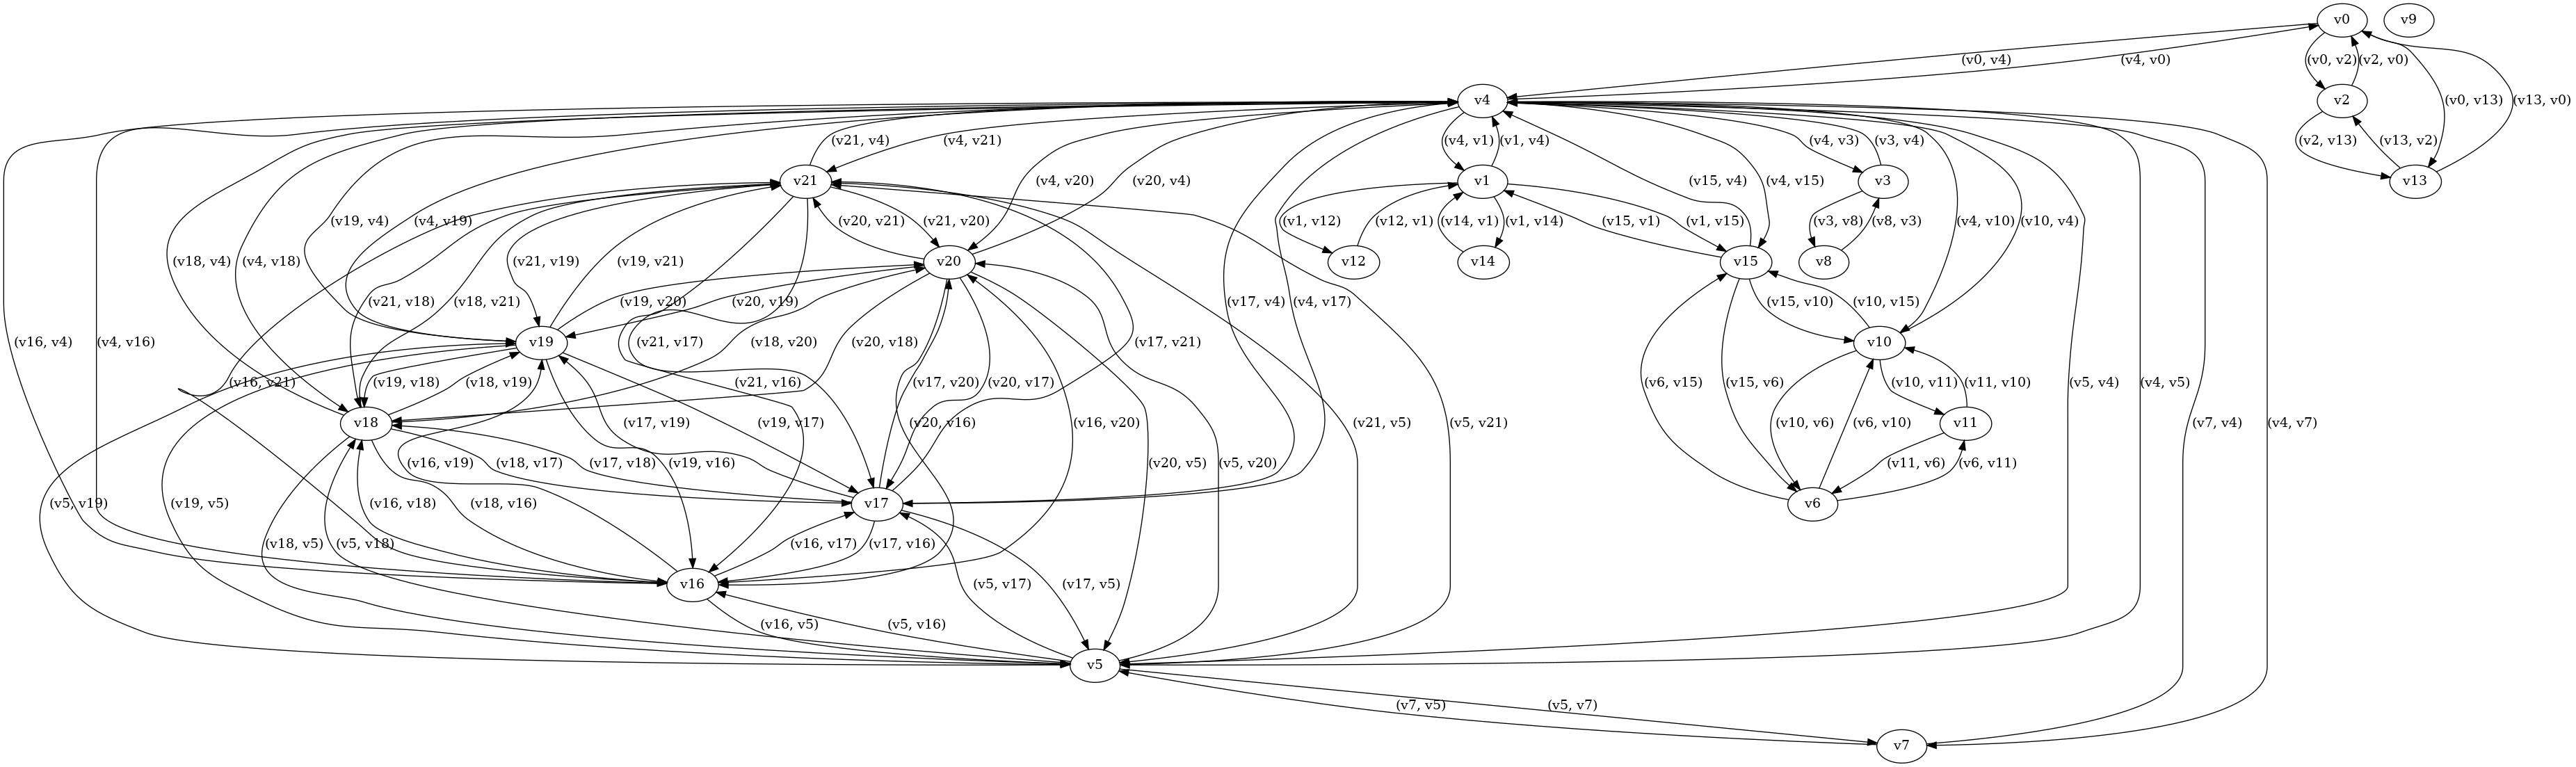

In [7]:
gcs = LinearGCS(regions)
display(Image(gcs.VisualizeGraph("png")))

# Demonstration

In [8]:
demo = getDemoConfigurations()

In [9]:
trajectories, run_time = getBezierGcsPath(plant, regions, demo, 3, 1)
print("Trajectory generation took", np.round(run_time, 4), "seconds of optimizer time.")
visualize_trajectory(trajectories, meshcat)

with open (os.path.join(GcsDir(), "data/bimanual/bezier_trajectory.html"), "w") as f:
   f.write(meshcat.StaticHtml())

In [ ]:
generate_segment_pics(trajectories, 0, meshcat)

In [ ]:
generate_segment_pics(trajectories, 1, meshcat)

In [ ]:
generate_segment_pics(trajectories, 2, meshcat)